In [1]:
import torch
from torch_geometric.utils import remove_self_loops, coalesce
from Models.GAE import Encoder, Decoder, GAE
# from GAE_1 import Encoder, Decoder, GAE
from torchinfo import summary
from torch_geometric.data import Data
import numpy as np
import torch.optim as optim
import scipy
import os
import Models.Get_data as Gd
from sklearn.model_selection import train_test_split
import torch.nn as nn
from copy import deepcopy

from tqdm import tqdm  
import matplotlib.pyplot as plt
from kmeans_pytorch import kmeans, kmeans_predict

import random

In [2]:
def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(66)  # 你可以选择任意一个数字作为种子
# 启用浮点数异常检测
# torch.autograd.set_detect_anomaly(True)

In [3]:
# 检查是否有 GPU 可用
if torch.cuda.is_available():
    print("GPU is available")
else:
    print("GPU is not available")

# 检查 GPU 的数量
num_gpus = torch.cuda.device_count()
print(f"Number of GPUs available: {num_gpus}")

# 获取每个 GPU 的名称
for i in range(num_gpus):
    print(f"GPU {i}: {torch.cuda.get_device_name(i)}")

# 设置默认使用的 GPU 设备
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

GPU is available
Number of GPUs available: 1
GPU 0: NVIDIA GeForce RTX 4060 Laptop GPU
Using device: cuda:0


In [4]:
directory = '/home/wl4023/data/Sibo_22Mar2024'
folders = [os.path.join(directory, f, 'hessian_') for f in os.listdir(directory) if f.startswith('case_')]

# Get data

In [5]:
xyfile = "/home/wl4023/data/Sibo_22Mar2024/case_0/hessian_/xy_coords.npy"
pos = torch.tensor(np.load(xyfile), dtype=torch.float32)

In [6]:
sparse_graph = scipy.sparse.load_npz('/home/wl4023/data/Sibo_22Mar2024/sparse_matrix_fixed_weighted.npz')
indices = np.array(sparse_graph.nonzero())
values = sparse_graph.data
shape = sparse_graph.shape

# sparse edge tensor
edge_tensor = torch.sparse_coo_tensor(indices, values, shape, dtype=torch.float).coalesce()
edge_index = edge_tensor.indices()
# edge_weight = edge_tensor.values()
# edge_weight = edge_weight.unsqueeze(1)
print(edge_tensor.shape)
print(edge_index)
# print(edge_weight)

torch.Size([97149, 97149])
tensor([[    0,     0,     1,  ..., 97148, 97148, 97148],
        [    1,     3,     0,  ..., 97145, 97146, 97147]])


In [7]:
distance = torch.norm(pos[edge_index[0]]-pos[edge_index[1]], dim=1)
print(distance)

tensor([0.0029, 0.0039, 0.0029,  ..., 0.0024, 0.0021, 0.0024])


In [8]:
edge_weight = 1/(distance)
edge_weight = edge_weight/torch.sum(edge_weight)*1000
edge_weight = edge_weight.unsqueeze(1)
print(f'{edge_weight.max():.8f}, {edge_weight.min():.8f}')

0.02281803, 0.00025737


In [9]:
latent_space = 25
num_mp_layers = [2, 2, 2]
num_clusters = [1000, latent_space]
clusters = []
centroids = []

In [10]:
centroid = deepcopy(pos)

for i in num_clusters:
    cluster, centroid = kmeans(centroid, i, device=pos.device)
    print(centroid.shape)
    clusters.append(cluster)
    centroids.append(centroid)
    
torch.save(centroids, 'centroids.pt')
torch.save(clusters, 'clusters.pt')

running k-means on cpu..


[running kmeans]: 81it [00:21,  3.77it/s, center_shift=0.000077, iteration=81, tol=0.000100]


torch.Size([1000, 2])
running k-means on cpu..


[running kmeans]: 28it [00:00, 911.95it/s, center_shift=0.000022, iteration=28, tol=0.000100]

torch.Size([25, 2])


## Train and val data

In [11]:
dataset, length = Gd.get_all_nodes(folders[:-1])

train_np, val_np = train_test_split(dataset, test_size=0.2, shuffle=True)
train_np = np.expand_dims(train_np[:, :, 0], axis=2)
val_np = np.expand_dims(val_np[:, :, 0], axis=2)

In [12]:
train_tensor = torch.tensor(train_np, dtype=torch.float)
train_tensor_set = Gd.MyDataset(train_tensor)
val_tensor = torch.tensor(val_np, dtype=torch.float)
val_tensor_set = Gd.MyDataset(val_tensor)

In [13]:
preprocessor = Gd.Preprocessor()
preprocessor.fit(torch.concat((train_tensor, val_tensor), axis=0))

In [14]:
print(preprocessor.mean)
print(preprocessor.std)

tensor(6.9571)
tensor(9.8111)


## Test data

In [15]:
test_np, length = Gd.get_all_nodes(folders[-1:])
test_np = np.expand_dims(test_np[:, :, 0], axis=2)
test_tensor = torch.tensor(test_np, dtype=torch.float)
test_tensor_set = Gd.MyDataset(test_tensor)

In [16]:
print(folders[-1:])

['/home/wl4023/data/Sibo_22Mar2024/case_23/hessian_']


# Train

In [17]:
class RMSELoss(nn.Module):
    def __init__(self):
        super(RMSELoss, self).__init__()
        self.mse = nn.MSELoss()

    def forward(self, y_true, y_pred):
        return torch.sqrt(self.mse(y_true, y_pred))

class NRMSE(nn.Module):
    def __init__(self, total_dataset):
        super(NRMSE, self).__init__()
        self.rmse = RMSELoss()
        self.factor = total_dataset.max()-total_dataset.min()

    def forward(self, y_true, y_pred):
        return self.rmse(y_true, y_pred)/self.factor

In [18]:
def check_for_nan_or_inf(tensor, name):
    if torch.isnan(tensor).any():
        print(f"Tensor {name} contains NaN values.")
    if torch.isinf(tensor).any():
        print(f"Tensor {name} contains Inf values.")

In [19]:
def train(model, train_set, val_set, edge_index, edge_attr, pos, criterion, optimizer, device, metric_train, metric_val, epochs=30):
    edge_index, edge_attr, pos = edge_index.to(device), edge_attr.to(device), pos.to(device)

    train_NRMSELoss_list = []
    train_RMSELoss_list = []

    val_NRMSELoss_list = []
    val_RMSELoss_list = []
    min_loss = 100000
    # ss = 0
    for i in range(epochs):
        model.train()
        train_loss = 0
        relative_train_loss = 0
        for x in tqdm(train_set):
            
            # for name, param in model.named_parameters():
            #     if param.grad is not None:
            #         if torch.isnan(param.grad).any():
            #             print(f"Gradient of parameter {name} contains NaN, {ss}")
            # ss = ss+1
            input = preprocessor.transform(x)
            input = input.to(device)
            x = x.to(device)
            optimizer.zero_grad()
            predict, _, _ = model(input, edge_index, edge_attr, pos)
            # print(predict.max(), predict.min(), x.max(), x.min())
            # 在计算损失之前检查输入
            check_for_nan_or_inf(predict, "y_pred")
            check_for_nan_or_inf(input, "y_true")
            loss = criterion(input, predict)
            loss.backward()

            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            optimizer.step()
            train_loss += criterion(x, preprocessor.inverse_transform(predict)).item()
            relative_train_loss += metric_train(x, preprocessor.inverse_transform(predict)).item()

        train_loss = train_loss/len(train_set)
        relative_train_loss /= len(train_set)
        train_RMSELoss_list.append(train_loss)
        train_NRMSELoss_list.append(relative_train_loss)

        model.eval()
        with torch.no_grad():
            val_loss = 0
            relative_val_loss = 0
            for x in val_set:
                input = preprocessor.transform(x)
                input = input.to(device)
                x = x.to(device)
                predict, _, _ = model(input, edge_index, edge_attr, pos)

                loss = criterion(input, predict)
                val_loss += criterion(x, preprocessor.inverse_transform(predict)).item()
                relative_val_loss += metric_val(x, preprocessor.inverse_transform(predict)).item()


            val_loss /= len(val_set)
            relative_val_loss /= len(val_set)

            val_RMSELoss_list.append(val_loss)
            val_NRMSELoss_list.append(relative_val_loss)

        print(f'Epoch {i + 1}/{epochs}, train Loss: {train_loss}, NRMSE_train_loss: {relative_train_loss}, val Loss: {val_loss}, NRMSE_val_loss: {relative_val_loss}')
        if min_loss >= relative_val_loss:
            min_loss = relative_val_loss
            torch.save(model.state_dict(), 'GAE_kmeans.pth')

    return train_RMSELoss_list, val_RMSELoss_list, train_NRMSELoss_list, val_NRMSELoss_list

In [20]:
# Define the weights initialization function
def initialize_weights(m):
    if isinstance(m, torch.nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            torch.nn.init.constant_(m.bias, 0)

In [21]:
model = GAE(1, 1, num_mp_layers, clusters, centroids, 16, 3)
model.apply(initialize_weights)
summary(model, input_data=(train_tensor[0], edge_index, edge_weight, pos))


Layer (type:depth-idx)                             Output Shape              Param #
GAE                                                [97149, 1]                --
├─Encoder: 1-1                                     [25, 16]                  --
│    └─ModuleList: 2-5                             --                        (recursive)
│    │    └─Linear: 3-1                            [97149, 16]               32
│    └─ELU: 2-2                                    [97149, 16]               --
│    └─ModuleList: 2-5                             --                        (recursive)
│    │    └─Linear: 3-2                            [97149, 16]               272
│    └─ELU: 2-4                                    [97149, 16]               --
│    └─ModuleList: 2-5                             --                        (recursive)
│    │    └─Linear: 3-3                            [97149, 16]               272
│    └─ELU: 2-6                                    [97149, 16]               --
│    └

In [22]:
criterion = RMSELoss()
optimizer = optim.Adam(model.parameters())
metric_train = NRMSE(train_tensor)
metric_val = NRMSE(val_tensor)
model.to(device)
train_RMSELoss_list, val_RMSELoss_list, train_NRMSELoss_list, val_NRMSELoss_list = train(model,
                                                                                         train_tensor_set,
                                                                                         val_tensor_set,
                                                                                         edge_index,
                                                                                         edge_weight,
                                                                                         pos,
                                                                                         criterion,
                                                                                         optimizer,
                                                                                         device,
                                                                                         metric_train,
                                                                                         metric_val, 
                                                                                         epochs=50)

100%|██████████| 2320/2320 [01:44<00:00, 22.19it/s]


Epoch 1/50, train Loss: 3.091339630974007, NRMSE_train_loss: 0.059447994794804955, val Loss: 2.634740996412162, NRMSE_val_loss: 0.050642269244417545


100%|██████████| 2320/2320 [01:40<00:00, 23.12it/s]


Epoch 2/50, train Loss: 2.2676493955711865, NRMSE_train_loss: 0.04360802294495757, val Loss: 2.224686204513599, NRMSE_val_loss: 0.042760619768423255


100%|██████████| 2320/2320 [01:40<00:00, 23.09it/s]


Epoch 3/50, train Loss: 1.9273575631130873, NRMSE_train_loss: 0.03706404216434999, val Loss: 2.176141201576282, NRMSE_val_loss: 0.04182753783474066


100%|██████████| 2320/2320 [01:40<00:00, 23.07it/s]


Epoch 4/50, train Loss: 1.824831709548317, NRMSE_train_loss: 0.0350924191413375, val Loss: 1.7501675968540127, NRMSE_val_loss: 0.03363991331164565


100%|██████████| 2320/2320 [01:40<00:00, 23.14it/s]


Epoch 5/50, train Loss: 1.7354204404778009, NRMSE_train_loss: 0.03337299610660732, val Loss: 1.7624810034858769, NRMSE_val_loss: 0.03387658890770299


100%|██████████| 2320/2320 [01:40<00:00, 23.14it/s]


Epoch 6/50, train Loss: 1.4721439734807815, NRMSE_train_loss: 0.028310059038781688, val Loss: 1.209510088789052, NRMSE_val_loss: 0.023247953248210253


100%|██████████| 2320/2320 [01:40<00:00, 23.12it/s]


Epoch 7/50, train Loss: 1.3028204216910848, NRMSE_train_loss: 0.02505388310488217, val Loss: 1.319354317003283, NRMSE_val_loss: 0.025359265569693826


100%|██████████| 2320/2320 [01:40<00:00, 23.11it/s]


Epoch 8/50, train Loss: 1.2071678065534295, NRMSE_train_loss: 0.023214435849463214, val Loss: 1.269150739188852, NRMSE_val_loss: 0.024394304323780897


100%|██████████| 2320/2320 [01:40<00:00, 23.10it/s]


Epoch 9/50, train Loss: 1.1403600653183872, NRMSE_train_loss: 0.02192968983606612, val Loss: 1.3225769194035695, NRMSE_val_loss: 0.025421207095496355


100%|██████████| 2320/2320 [01:40<00:00, 23.19it/s]


Epoch 10/50, train Loss: 1.0910340480313732, NRMSE_train_loss: 0.020981126051428246, val Loss: 1.306799294003125, NRMSE_val_loss: 0.025117945884643444


100%|██████████| 2320/2320 [01:39<00:00, 23.32it/s]


Epoch 11/50, train Loss: 1.0589457338290482, NRMSE_train_loss: 0.020364051846112927, val Loss: 1.2156046040613075, NRMSE_val_loss: 0.023365095819764096


100%|██████████| 2320/2320 [01:39<00:00, 23.35it/s]


Epoch 12/50, train Loss: 1.0369857249107084, NRMSE_train_loss: 0.019941749975611135, val Loss: 1.3328484363083182, NRMSE_val_loss: 0.025618635614980654


100%|██████████| 2320/2320 [01:39<00:00, 23.32it/s]


Epoch 13/50, train Loss: 1.0062602311629674, NRMSE_train_loss: 0.01935088347808201, val Loss: 1.272001846494346, NRMSE_val_loss: 0.02444910529663722


100%|██████████| 2320/2320 [01:39<00:00, 23.32it/s]


Epoch 14/50, train Loss: 0.9970233165980156, NRMSE_train_loss: 0.0191732530449497, val Loss: 1.1398660653624042, NRMSE_val_loss: 0.021909327882920104


100%|██████████| 2320/2320 [01:39<00:00, 23.35it/s]


Epoch 15/50, train Loss: 0.9618403751820582, NRMSE_train_loss: 0.018496667625731787, val Loss: 0.9963387642441125, NRMSE_val_loss: 0.019150594399503337


100%|██████████| 2320/2320 [01:39<00:00, 23.30it/s]


Epoch 16/50, train Loss: 0.9472797962451547, NRMSE_train_loss: 0.018216660458108828, val Loss: 1.0908513267492426, NRMSE_val_loss: 0.020967217143384162


100%|██████████| 2320/2320 [01:39<00:00, 23.34it/s]


Epoch 17/50, train Loss: 0.9283106602728367, NRMSE_train_loss: 0.01785187456638408, val Loss: 0.9690137954621479, NRMSE_val_loss: 0.01862538202489116


100%|██████████| 2320/2320 [01:39<00:00, 23.32it/s]


Epoch 18/50, train Loss: 0.9060599601731218, NRMSE_train_loss: 0.01742398257142511, val Loss: 1.03041625531583, NRMSE_val_loss: 0.019805596687766755


100%|██████████| 2320/2320 [01:39<00:00, 23.29it/s]


Epoch 19/50, train Loss: 0.8934097342610616, NRMSE_train_loss: 0.01718071243998691, val Loss: 0.9367128854681706, NRMSE_val_loss: 0.018004527297432953


100%|██████████| 2320/2320 [01:39<00:00, 23.34it/s]


Epoch 20/50, train Loss: 0.8693922543898225, NRMSE_train_loss: 0.016718844397611725, val Loss: 0.9945979770915262, NRMSE_val_loss: 0.019117134754899248


100%|██████████| 2320/2320 [01:39<00:00, 23.34it/s]


Epoch 21/50, train Loss: 0.8733257302950168, NRMSE_train_loss: 0.016794487087513674, val Loss: 0.9562781659436637, NRMSE_val_loss: 0.018380590946943467


100%|██████████| 2320/2320 [01:39<00:00, 23.30it/s]


Epoch 22/50, train Loss: 0.8495212329198317, NRMSE_train_loss: 0.01633671480491918, val Loss: 1.2129731171090028, NRMSE_val_loss: 0.023314516056842843


100%|██████████| 2320/2320 [01:39<00:00, 23.28it/s]


Epoch 23/50, train Loss: 0.8640753358891555, NRMSE_train_loss: 0.016616597403782213, val Loss: 1.048074725064738, NRMSE_val_loss: 0.0201450095712689


100%|██████████| 2320/2320 [01:39<00:00, 23.32it/s]


Epoch 24/50, train Loss: 0.8377233480745605, NRMSE_train_loss: 0.01610983563652302, val Loss: 1.0270431771874429, NRMSE_val_loss: 0.019740762870260997


100%|██████████| 2320/2320 [01:39<00:00, 23.33it/s]


Epoch 25/50, train Loss: 0.8430344396495614, NRMSE_train_loss: 0.01621197053689935, val Loss: 0.9434872832277725, NRMSE_val_loss: 0.018134737831283488


100%|██████████| 2320/2320 [01:39<00:00, 23.25it/s]


Epoch 26/50, train Loss: 0.8306834729067211, NRMSE_train_loss: 0.01597445533181348, val Loss: 0.952579983811954, NRMSE_val_loss: 0.018309508304208005


100%|██████████| 2320/2320 [01:39<00:00, 23.33it/s]


Epoch 27/50, train Loss: 0.8062738591965674, NRMSE_train_loss: 0.015505046331060745, val Loss: 0.9819369602819968, NRMSE_val_loss: 0.01887377776920089


100%|██████████| 2320/2320 [01:39<00:00, 23.32it/s]


Epoch 28/50, train Loss: 0.8215648115291421, NRMSE_train_loss: 0.01579909891929831, val Loss: 0.8417851727327396, NRMSE_val_loss: 0.01617992490104496


100%|██████████| 2320/2320 [01:39<00:00, 23.31it/s]


Epoch 29/50, train Loss: 0.8003524715080857, NRMSE_train_loss: 0.01539117510200695, val Loss: 0.8481783991872237, NRMSE_val_loss: 0.016302808869533756


100%|██████████| 2320/2320 [01:39<00:00, 23.28it/s]


Epoch 30/50, train Loss: 0.7843152104074071, NRMSE_train_loss: 0.01508277062961936, val Loss: 0.9214501579773837, NRMSE_val_loss: 0.01771116293565338


100%|██████████| 2320/2320 [01:39<00:00, 23.31it/s]


Epoch 31/50, train Loss: 0.7870073144452582, NRMSE_train_loss: 0.01513454112914744, val Loss: 0.921731636005229, NRMSE_val_loss: 0.01771657323336293


100%|██████████| 2320/2320 [01:39<00:00, 23.30it/s]


Epoch 32/50, train Loss: 0.7879868285216648, NRMSE_train_loss: 0.01515337766117039, val Loss: 0.80538905703559, NRMSE_val_loss: 0.015480356328269659


100%|██████████| 2320/2320 [01:39<00:00, 23.21it/s]


Epoch 33/50, train Loss: 0.7689012991168118, NRMSE_train_loss: 0.014786353465249955, val Loss: 0.9933094071930852, NRMSE_val_loss: 0.019092367167969974


100%|██████████| 2320/2320 [01:39<00:00, 23.31it/s]


Epoch 34/50, train Loss: 0.7792757040724672, NRMSE_train_loss: 0.014985858425869334, val Loss: 0.9593739740293602, NRMSE_val_loss: 0.01844009536334538


100%|██████████| 2320/2320 [01:39<00:00, 23.29it/s]


Epoch 35/50, train Loss: 0.7718818201779806, NRMSE_train_loss: 0.014843670354859005, val Loss: 0.8454946292371586, NRMSE_val_loss: 0.01625122424648625


100%|██████████| 2320/2320 [01:39<00:00, 23.29it/s]


Epoch 36/50, train Loss: 0.7452317158820043, NRMSE_train_loss: 0.014331175636195032, val Loss: 0.8203882409066989, NRMSE_val_loss: 0.015768655200071376


100%|██████████| 2320/2320 [01:39<00:00, 23.34it/s]


Epoch 37/50, train Loss: 0.7532938115009716, NRMSE_train_loss: 0.014486213751209514, val Loss: 0.8140320223210187, NRMSE_val_loss: 0.015646482528596795


100%|██████████| 2320/2320 [01:39<00:00, 23.32it/s]


Epoch 38/50, train Loss: 0.7511501640498895, NRMSE_train_loss: 0.014444990326893307, val Loss: 0.8942183821108834, NRMSE_val_loss: 0.01718774184741176


100%|██████████| 2320/2320 [01:39<00:00, 23.30it/s]


Epoch 39/50, train Loss: 0.7476425152753705, NRMSE_train_loss: 0.014377536502333583, val Loss: 0.8472013827027945, NRMSE_val_loss: 0.016284029687562124


100%|██████████| 2320/2320 [01:39<00:00, 23.31it/s]


Epoch 40/50, train Loss: 0.7378004552539567, NRMSE_train_loss: 0.014188268797869536, val Loss: 0.8038707592364015, NRMSE_val_loss: 0.015451173245272566


100%|██████████| 2320/2320 [01:39<00:00, 23.32it/s]


Epoch 41/50, train Loss: 0.7422939126058642, NRMSE_train_loss: 0.01427468021208589, val Loss: 0.8640518046530157, NRMSE_val_loss: 0.016607911075497497


100%|██████████| 2320/2320 [01:39<00:00, 23.33it/s]


Epoch 42/50, train Loss: 0.7325360949343905, NRMSE_train_loss: 0.01408703256055215, val Loss: 0.7422644284907086, NRMSE_val_loss: 0.014267039972212936


100%|██████████| 2320/2320 [01:39<00:00, 23.33it/s]


Epoch 43/50, train Loss: 0.7276414104640998, NRMSE_train_loss: 0.013992905344789976, val Loss: 0.8487115969174894, NRMSE_val_loss: 0.016313057469107724


100%|██████████| 2320/2320 [01:39<00:00, 23.28it/s]


Epoch 44/50, train Loss: 0.7104422242444908, NRMSE_train_loss: 0.013662156438984876, val Loss: 0.9793676637883844, NRMSE_val_loss: 0.018824393386502974


100%|██████████| 2320/2320 [01:39<00:00, 23.27it/s]


Epoch 45/50, train Loss: 0.7343089379723473, NRMSE_train_loss: 0.014121125192443663, val Loss: 0.6889088881169928, NRMSE_val_loss: 0.013241494915464187


100%|██████████| 2320/2320 [01:39<00:00, 23.29it/s]


Epoch 46/50, train Loss: 0.7126670188398968, NRMSE_train_loss: 0.013704940350274636, val Loss: 0.8062994032841304, NRMSE_val_loss: 0.01549785407219917


100%|██████████| 2320/2320 [01:39<00:00, 23.32it/s]


Epoch 47/50, train Loss: 0.7144148022418135, NRMSE_train_loss: 0.013738551090726355, val Loss: 0.7681012900225047, NRMSE_val_loss: 0.014763649400917749


100%|██████████| 2320/2320 [01:39<00:00, 23.34it/s]


Epoch 48/50, train Loss: 0.6975199071465639, NRMSE_train_loss: 0.013413653885825248, val Loss: 0.7213283532652361, NRMSE_val_loss: 0.013864628373693419


100%|██████████| 2320/2320 [01:39<00:00, 23.24it/s]


Epoch 49/50, train Loss: 0.702370243452104, NRMSE_train_loss: 0.013506928251369793, val Loss: 0.6967301540462107, NRMSE_val_loss: 0.013391827184361695


100%|██████████| 2320/2320 [01:39<00:00, 23.29it/s]


Epoch 50/50, train Loss: 0.7101120799362403, NRMSE_train_loss: 0.013655807618714131, val Loss: 0.8023047219833424, NRMSE_val_loss: 0.015421072477153663


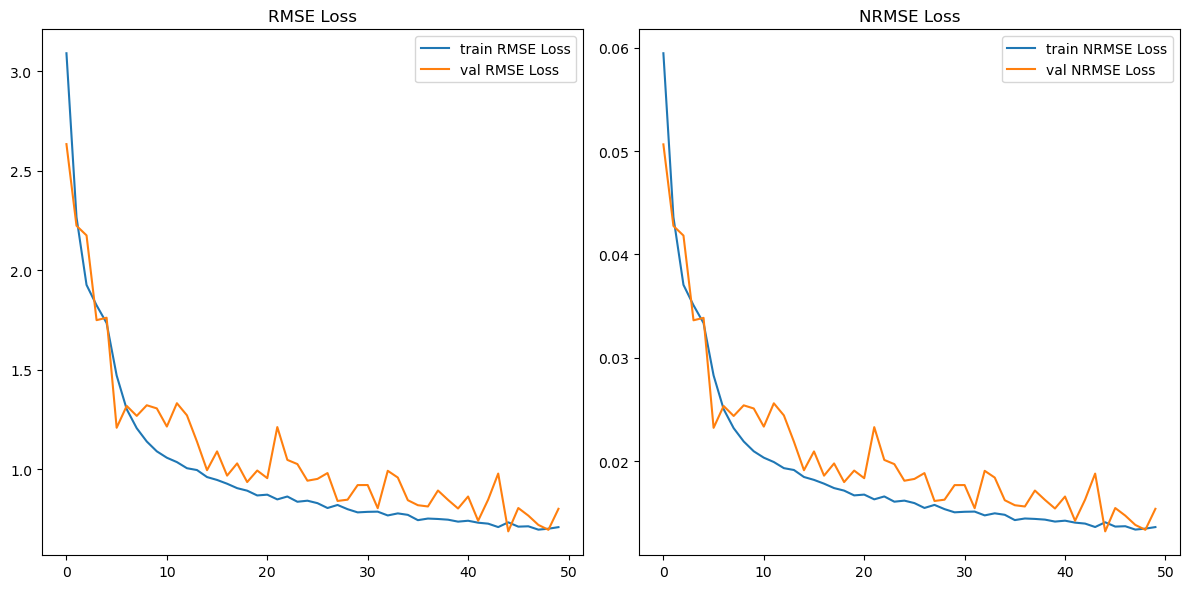

In [23]:
fig1, axs = plt.subplots(1, 2, figsize=(12, 6))
train_RMSELoss_list, val_RMSELoss_list, train_NRMSELoss_list, val_NRMSELoss_list
axs[0].plot(train_RMSELoss_list, label='train RMSE Loss')
axs[0].plot(val_RMSELoss_list, label='val RMSE Loss')
axs[0].set_title("RMSE Loss")
axs[0].legend()

axs[1].plot(train_NRMSELoss_list, label='train NRMSE Loss')
axs[1].plot(val_NRMSELoss_list, label='val NRMSE Loss')
axs[1].set_title("NRMSE Loss")
axs[1].legend()

plt.tight_layout()  # 调整布局以防止重叠
plt.savefig('GAE_train_loss.png')  # 你可以更改文件名或格式
plt.show()

# Result

In [24]:
def draw_pic(x, y, coords):
    # 计算所有子图中颜色值的全局最小值和最大值
    vmin = min([x[i].min() for i in range(5)] + [y[i].min() for i in range(5)])
    vmax = max([x[i].max() for i in range(5)] + [y[i].max() for i in range(5)])

    fig1, axs = plt.subplots(1, 5, figsize=(30, 6), sharey=True)
    for i in range(5):
        im = axs[i].scatter(coords[:, 0], coords[:, 1], s=5, c=x[i], cmap='bwr', vmin=vmin, vmax=vmax)
        axs[i].set_title('input')
    fig1.colorbar(im, ax=axs.ravel().tolist(), orientation='vertical')
    plt.show()
    plt.close()

    fig2, axs = plt.subplots(1, 5, figsize=(30, 6), sharey=True)
    for i in range(5):
        im = axs[i].scatter(coords[:, 0], coords[:, 1], s=5, c=y[i], cmap='bwr', vmin=vmin, vmax=vmax)
        axs[i].set_title('recon')
    fig2.colorbar(im, ax=axs.ravel().tolist(), orientation='vertical')
    plt.show()
    plt.close()

# 示例使用方式
# x = [np.random.randn(100) for _ in range(5)]
# y = [np.random.randn(100) for _ in range(5)]
# coords = np.random.randn(100, 2)
# draw_pic(x, y, coords)


In [25]:
clusters = torch.load('./clusters.pt')
centroids = torch.load('./centroids.pt')
# num_mp_layers = [2, 2, 2]

In [26]:
gae = GAE(1, 1, num_mp_layers, clusters, centroids, 16, 3)
criterion = RMSELoss()
metric = NRMSE(test_tensor)
# 加载保存的状态字典
state_dict = torch.load('./GAE_kmeans.pth')
gae.load_state_dict(state_dict)

<All keys matched successfully>

In [27]:
for param in gae.parameters():
    param.requires_grad = False

In [28]:
gae.eval()
y = torch.zeros_like(test_tensor)
test_RMSE_Loss = []
test_NRMSE_Loss = []
with torch.no_grad():
    ave_rmse = 0
    ave_nrmse = 0
    for i in range(len(test_tensor)):
        input = preprocessor.transform(test_tensor[i])
        predict, _, _ = gae(input, edge_index, edge_weight, pos)
        y[i] = preprocessor.inverse_transform(predict)
        rmse = criterion(test_tensor[i], y[i]).item()
        nrmse = metric(test_tensor[i], y[i]).item()

        test_RMSE_Loss.append(rmse)
        test_NRMSE_Loss.append(nrmse)

        ave_rmse += rmse
        ave_nrmse += nrmse

ave_rmse /= len(test_tensor)
ave_nrmse /= len(test_tensor)


print(f"RMSE loss: {ave_rmse}")
print(f"NRMSE loss: {ave_nrmse}")
    

RMSE loss: 0.40363096445798874
NRMSE loss: 0.02295344976708293


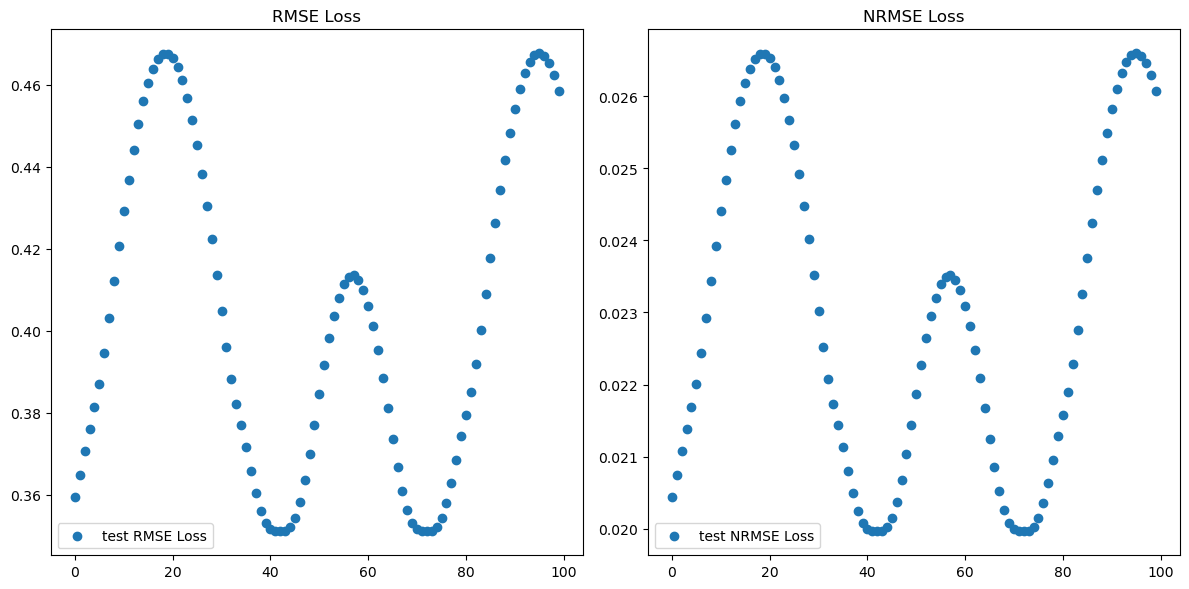

In [29]:
test_RMSE_Loss = np.array(test_RMSE_Loss)
test_NRMSE_Loss = np.array(test_NRMSE_Loss)

# 保存数组到 .npy 文件
np.save('test_rmse.npy', test_RMSE_Loss)
np.save('test_nrmse.npy', test_NRMSE_Loss)


fig1, axs = plt.subplots(1, 2, figsize=(12, 6))

x = np.arange(0, 100)

axs[0].scatter(x, test_RMSE_Loss, label='test RMSE Loss')
axs[0].set_title("RMSE Loss")
axs[0].legend()

axs[1].scatter(x, test_NRMSE_Loss, label='test NRMSE Loss')
axs[1].set_title("NRMSE Loss")
axs[1].legend()


plt.tight_layout()  # 调整布局以防止重叠
plt.savefig('GAE_test_loss.png')  # 你可以更改文件名或格式
plt.show()

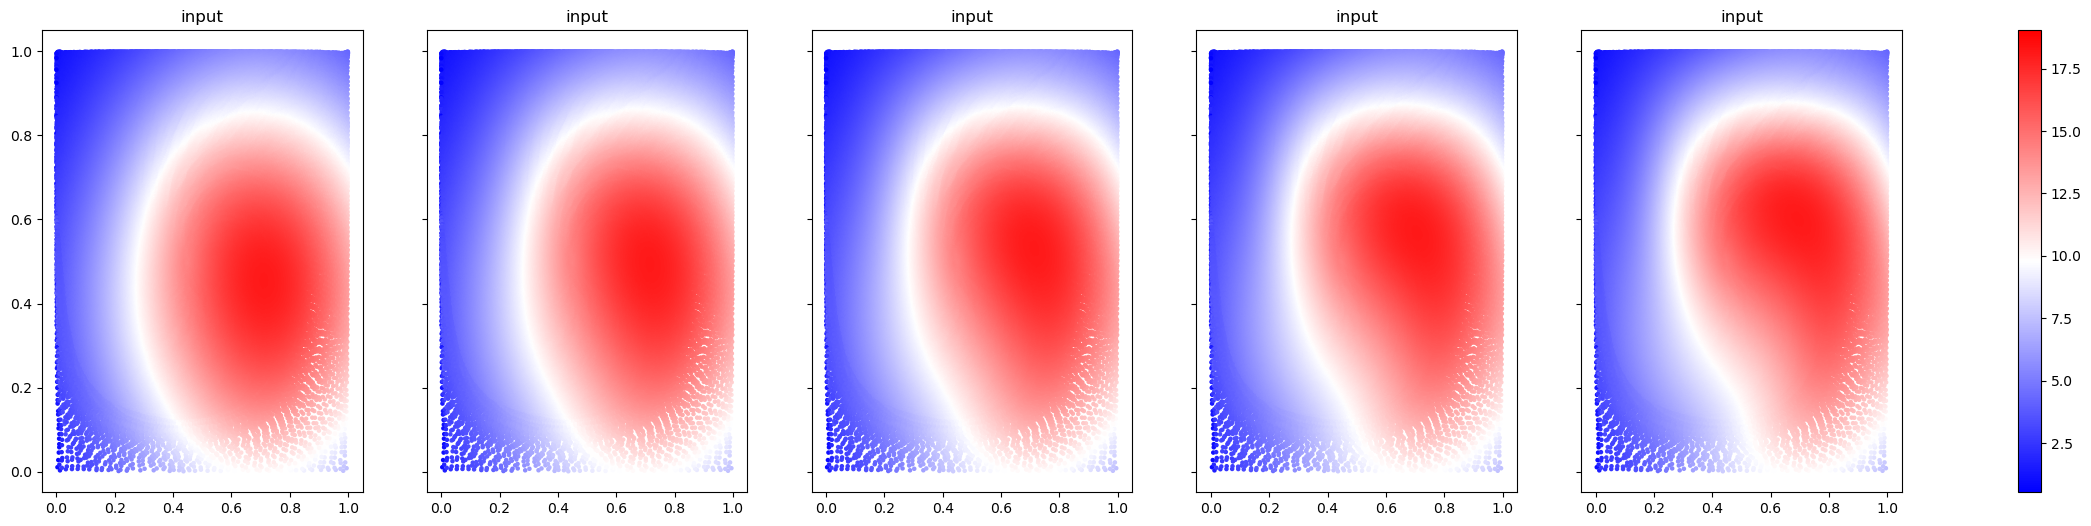

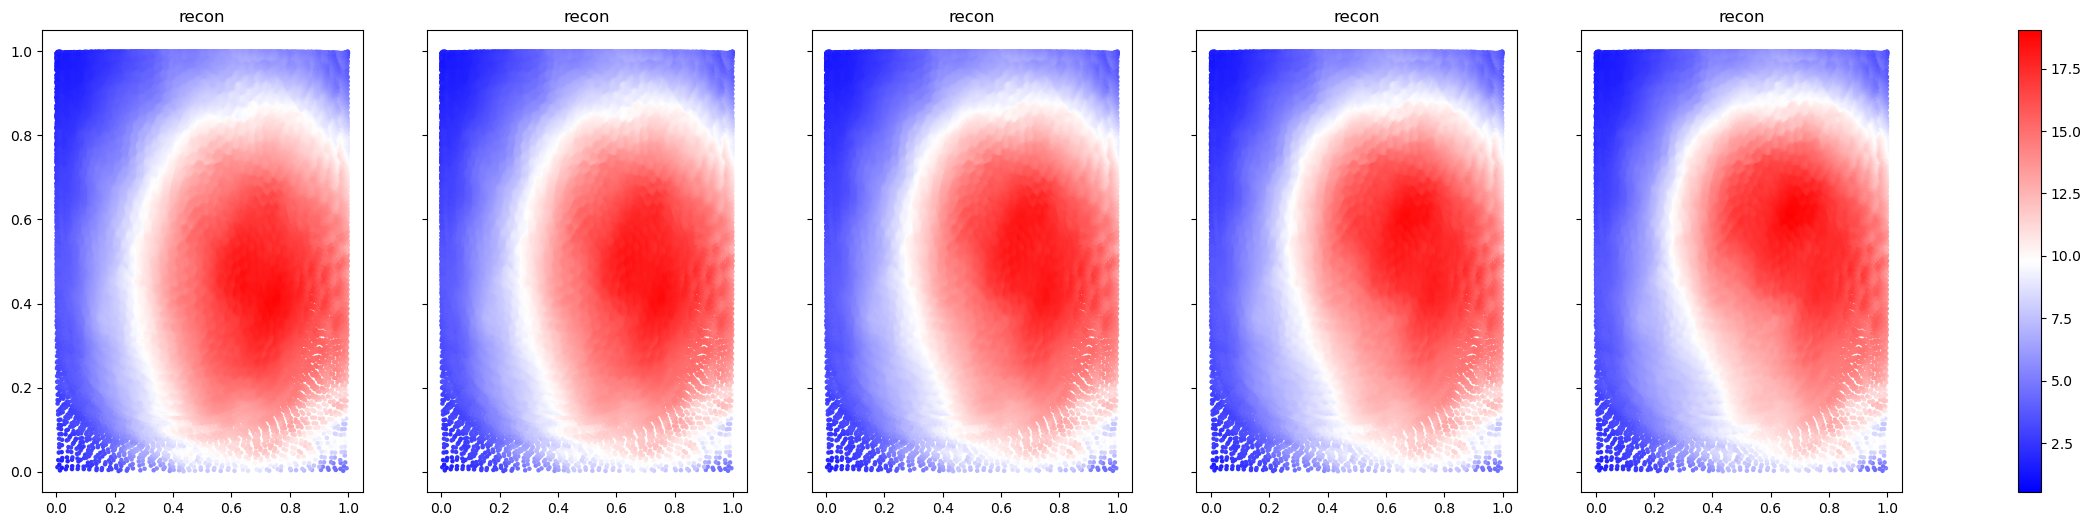

In [30]:
x = test_tensor_set[0:5]
recon_x = y[0:5]


x_np = x.cpu().detach().numpy()
recon_x_np = recon_x.cpu().detach().numpy()
pos_np = pos.cpu().detach().numpy()
draw_pic(x_np, recon_x_np, pos_np)